In [117]:
import numpy as np
import pandas as pd
from scipy import stats
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import seaborn
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.preprocessing import MultiLabelBinarizer
porter = PorterStemmer()
lancaster=LancasterStemmer()

from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

def score_corr(model, X_test, y_test, df):
    accept = 0
    total = len(X_test)
    
    datafr = pd.DataFrame(y_test)
    index_list = datafr.reset_index()['index'].tolist()
    
    predict = model.predict(X_test)
    predict_list = predict.tolist()
    
    for i in range(len(X_test)):
        accept_list = []
        index = index_list[i]
        accept_list.append(df['genres_number'][index])
        if index > 1:
            index_m1 = index - 1
            index_m2 = index - 2
            index_p1 = index + 1
            index_p2 = index + 2
            if df['plot'][index] == df['plot'][index_m1]:
                accept_list.append(df['genres_number'][index_m1])
            if df['plot'][index] == df['plot'][index_m2]:
                accept_list.append(df['genres_number'][index_m2])
            if index_p1 <= max(index_list):
                if df['plot'][index] == df['plot'][index_p1]:
                    accept_list.append(df['genres_number'][index_p1])
            if index_p2 <= max(index_list):      
                if df['plot'][index] == df['plot'][index_p2]:
                    accept_list.append(df['genres_number'][index_p2])
        elif index == 1:
            index_m1 = index - 1
            index_p1 = index + 1
            index_p2 = index + 2
            if df['plot'][index] == df['plot'][index_m1]:
                accept_list.append(df['genres_number'][index_m1])
            if df['plot'][index] == df['plot'][index_p1]:
                accept_list.append(df['genres_number'][index_p1])
            if df['plot'][index] == df['plot'][index_p2]:
                accept_list.append(df['genres_number'][index_p2])
        else:
            index_p1 = index + 1
            index_p2 = index + 2
            if df['plot'][index] == df['plot'][index_p1]:
                accept_list.append(df['genres_number'][index_p1])
            if df['plot'][index] == df['plot'][index_p2]:
                accept_list.append(df['genres_number'][index_p2])
                
        if predict_list[i] in accept_list:
            accept = accept + 1
        
    score = accept / total
    print ('The corrected score for testing data is: ', score)
    return score

In [58]:
wiki = pd.read_json('wiki-company.json.gz', orient='record', lines=True)
rt = pd.read_json('rotten-tomatoes.json.gz', orient='record', lines=True)
omdb = pd.read_json('omdb-data.json.gz', orient='record', lines=True)

In [59]:
genres = []
for i in omdb['omdb_genres']:
    for j in i:
        if j not in genres:
            genres.append(j)
genres

['Drama',
 'History',
 'War',
 'Action',
 'Adventure',
 'Thriller',
 'Comedy',
 'Horror',
 'Crime',
 'Sci-Fi',
 'Fantasy',
 'Mystery',
 'Biography',
 'Music',
 'Family',
 'Musical',
 'Romance',
 'Animation',
 'Documentary',
 'Short',
 'Sport',
 'N/A',
 'Western',
 'News',
 'Talk-Show',
 'Film-Noir',
 'Adult']

In [60]:
def get_genres(omdb):
    genres = []
    for i in omdb['omdb_genres']:
        for j in i:
            if j not in genres:
                genres.append(j)
    dic_genres = {}
    for i in genres:
        dic_genres.setdefault(i, [])

    for index,j in enumerate(omdb['omdb_genres']):
        for i in j:
            if i in dic_genres:
                dic_genres[i].append(omdb['omdb_plot'][index])
    return dic_genres
genres_comment = get_genres(omdb)

In [61]:
def each_number_genres(genres_comment):
    number_movies = {}
    for i in genres_comment:
        length = len(genres_comment[i])
        number_movies.setdefault(i,length)
    return number_movies
number_movies = each_number_genres(genres_comment)
number_movies

{'Action': 1964,
 'Adult': 4,
 'Adventure': 1638,
 'Animation': 546,
 'Biography': 688,
 'Comedy': 3134,
 'Crime': 1530,
 'Documentary': 757,
 'Drama': 4676,
 'Family': 676,
 'Fantasy': 774,
 'Film-Noir': 83,
 'History': 387,
 'Horror': 1152,
 'Music': 318,
 'Musical': 167,
 'Mystery': 649,
 'N/A': 22,
 'News': 18,
 'Romance': 1527,
 'Sci-Fi': 801,
 'Short': 68,
 'Sport': 142,
 'Talk-Show': 1,
 'Thriller': 1190,
 'War': 304,
 'Western': 132}

In [62]:
filtered_movies = {}
for i in number_movies:
    if number_movies[i] >= 800:
        filtered_movies.update({i: number_movies[i]})
filtered_movies

{'Action': 1964,
 'Adventure': 1638,
 'Comedy': 3134,
 'Crime': 1530,
 'Drama': 4676,
 'Horror': 1152,
 'Romance': 1527,
 'Sci-Fi': 801,
 'Thriller': 1190}

In [63]:
def get_partition(number_movies):
    total = 0
    for x in number_movies:
        total += number_movies[x]
    for x in number_movies:
        number_movies[x] = number_movies[x]/total
    return number_movies
data = get_partition(filtered_movies)

In [64]:
seaborn.set()
# df = pd.DataFrame.from_dict(data,orient='index',columns = ['partition'])
# df.plot.pie(y='partition', figsize=(10, 15))

In [65]:
filtered_genres = [x for x in filtered_movies]
print(filtered_genres)

['Drama', 'Action', 'Adventure', 'Thriller', 'Comedy', 'Horror', 'Crime', 'Sci-Fi', 'Romance']


In [66]:
omdb

imdb_id                                        omdb_awards  \
0     tt0060814     Nominated for 2 Oscars. Another 2 nominations.   
1     tt2379713      Won 1 Oscar. Another 7 wins & 32 nominations.   
2     tt0230575                                                N/A   
3     tt0065988  Nominated for 1 Oscar. Another 5 wins & 8 nomi...   
4     tt1995390                                     2 nominations.   
5     tt0066921  Nominated for 4 Oscars. Another 9 wins & 19 no...   
6     tt1298650                           2 wins & 31 nominations.   
7     tt0069947  Nominated for 1 Oscar. Another 1 win & 10 nomi...   
8     tt0116629     Won 1 Oscar. Another 34 wins & 34 nominations.   
9     tt0057012  Nominated for 4 Oscars. Another 13 wins & 7 no...   
10    tt1568346     Won 1 Oscar. Another 27 wins & 90 nominations.   
11    tt1504320  Won 4 Oscars. Another 102 wins & 194 nominations.   
12    tt0120737  Won 4 Oscars. Another 113 wins & 123 nominations.   
13    tt0800080                             1 win & 8 nominations.   
14    tt1226229                                    14 nominations.   
15    tt2395427                           7 wins & 45 nominations.   
16    tt0368891                             1 win & 9 nominations.   
17    tt0057076  Nominated for 1 Golden Globe. Another 3 wins &...   
18    tt0371746  Nominated for 2 Oscars. Another 20 wins & 65 n...   
19    tt2381249                           6 wins & 23 nominations.   
20    tt0434409                           7 wins & 27 nominations.   
21    tt0816711                           3 wins & 24 nominations.   
22    tt0241527  Nominated for 3 Oscars. Another 17 wins & 62 n...   
23    tt0480249                           9 wins & 22 nominations.   
24    tt0115956                            9 wins & 7 nominations.   
25    tt1194173                            1 win & 11 nominations.   
26    tt2872732                            1 win & 11 nominations.   
27    tt0383574     Won 1 Oscar. Another 42 wins & 53 nominations.   
28    tt0102926    Won 5 Oscars. Another 54 wins & 44 nominations.   
29    tt0064757  Nominated for 1 Golden Globe. Another 1 win & ...   
...         ...                                                ...   
9646  tt0369738                                                N/A   
9647  tt3469798                                     2 nominations.   
9648  tt0432348                            4 wins & 8 nominations.   
9649  tt0220570                                            2 wins.   
9650  tt0029855  Nominated for 4 Oscars. Another 1 win & 1 nomi...   
9651  tt0299422                                             1 win.   
9652  tt0387564                           8 wins & 10 nominations.   
9653  tt1821362                                                N/A   
9654  tt3276924                                                N/A   
9655  tt3805180                                                N/A   
9656  tt0092033                                                N/A   
9657  tt0120514  Nominated for 1 Golden Globe. Another 4 wins &...   
9658  tt0078870                              1 win & 1 nomination.   
9659  tt1819769                                                N/A   
9660  tt0087313                                                N/A   
9661  tt2318405                            4 wins & 7 nominations.   
9662  tt0254617                                                N/A   
9663  tt0266489                                     2 nominations.   
9664  tt0280962                            4 wins & 2 nominations.   
9665  tt0298491                           10 wins & 3 nominations.   
9666  tt0978702                                                N/A   
9667  tt0096219                            3 wins & 5 nominations.   
9668  tt1986994                                                N/A   
9669  tt1183487                                            5 wins.   
9670  tt0113101                              1 win & 1 nomination.   
9671  tt0052365   

In [67]:
# filter small numbers genres

for index, genres in enumerate(omdb['omdb_genres']):
    temp = []
    for i in genres:
        if i in filtered_genres:
            temp.append(i)
    if temp != []:
        omdb['omdb_genres'][index] = temp
    else:
        omdb['omdb_genres'][index] = []


In [68]:
omdb = omdb[omdb.astype(str)['omdb_genres'] != '[]'].reset_index(drop=True)

In [69]:
omdb

imdb_id                                        omdb_awards  \
0     tt0060814     Nominated for 2 Oscars. Another 2 nominations.   
1     tt2379713      Won 1 Oscar. Another 7 wins & 32 nominations.   
2     tt0230575                                                N/A   
3     tt0065988  Nominated for 1 Oscar. Another 5 wins & 8 nomi...   
4     tt1995390                                     2 nominations.   
5     tt0066921  Nominated for 4 Oscars. Another 9 wins & 19 no...   
6     tt1298650                           2 wins & 31 nominations.   
7     tt0069947  Nominated for 1 Oscar. Another 1 win & 10 nomi...   
8     tt0116629     Won 1 Oscar. Another 34 wins & 34 nominations.   
9     tt0057012  Nominated for 4 Oscars. Another 13 wins & 7 no...   
10    tt1568346     Won 1 Oscar. Another 27 wins & 90 nominations.   
11    tt1504320  Won 4 Oscars. Another 102 wins & 194 nominations.   
12    tt0120737  Won 4 Oscars. Another 113 wins & 123 nominations.   
13    tt0800080                             1 win & 8 nominations.   
14    tt1226229                                    14 nominations.   
15    tt2395427                           7 wins & 45 nominations.   
16    tt0368891                             1 win & 9 nominations.   
17    tt0057076  Nominated for 1 Golden Globe. Another 3 wins &...   
18    tt0371746  Nominated for 2 Oscars. Another 20 wins & 65 n...   
19    tt2381249                           6 wins & 23 nominations.   
20    tt0434409                           7 wins & 27 nominations.   
21    tt0816711                           3 wins & 24 nominations.   
22    tt0241527  Nominated for 3 Oscars. Another 17 wins & 62 n...   
23    tt0480249                           9 wins & 22 nominations.   
24    tt0115956                            9 wins & 7 nominations.   
25    tt1194173                            1 win & 11 nominations.   
26    tt2872732                            1 win & 11 nominations.   
27    tt0383574     Won 1 Oscar. Another 42 wins & 53 nominations.   
28    tt0102926    Won 5 Oscars. Another 54 wins & 44 nominations.   
29    tt0064757  Nominated for 1 Golden Globe. Another 1 win & ...   
...         ...                                                ...   
8846  tt0369738                                                N/A   
8847  tt3469798                                     2 nominations.   
8848  tt0432348                            4 wins & 8 nominations.   
8849  tt0220570                                            2 wins.   
8850  tt0029855  Nominated for 4 Oscars. Another 1 win & 1 nomi...   
8851  tt0299422                                             1 win.   
8852  tt0387564                           8 wins & 10 nominations.   
8853  tt1821362                                                N/A   
8854  tt3276924                                                N/A   
8855  tt3805180                                                N/A   
8856  tt0092033                                                N/A   
8857  tt0120514  Nominated for 1 Golden Globe. Another 4 wins &...   
8858  tt0078870                              1 win & 1 nomination.   
8859  tt1819769                                                N/A   
8860  tt0087313                                                N/A   
8861  tt2318405                            4 wins & 7 nominations.   
8862  tt0254617                                                N/A   
8863  tt0266489                                     2 nominations.   
8864  tt0280962                            4 wins & 2 nominations.   
8865  tt0298491                           10 wins & 3 nominations.   
8866  tt0978702                                                N/A   
8867  tt0096219                            3 wins & 5 nominations.   
8868  tt1986994                                                N/A   
8869  tt1183487                                            5 wins.   
8870  tt0113101                              1 win & 1 nomination.   
8871  tt0052365   

In [70]:
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text
omdb['omdb_plot'] = omdb['omdb_plot'].apply(lambda x: clean_text(x))

In [71]:
omdb

imdb_id                                        omdb_awards  \
0     tt0060814     Nominated for 2 Oscars. Another 2 nominations.   
1     tt2379713      Won 1 Oscar. Another 7 wins & 32 nominations.   
2     tt0230575                                                N/A   
3     tt0065988  Nominated for 1 Oscar. Another 5 wins & 8 nomi...   
4     tt1995390                                     2 nominations.   
5     tt0066921  Nominated for 4 Oscars. Another 9 wins & 19 no...   
6     tt1298650                           2 wins & 31 nominations.   
7     tt0069947  Nominated for 1 Oscar. Another 1 win & 10 nomi...   
8     tt0116629     Won 1 Oscar. Another 34 wins & 34 nominations.   
9     tt0057012  Nominated for 4 Oscars. Another 13 wins & 7 no...   
10    tt1568346     Won 1 Oscar. Another 27 wins & 90 nominations.   
11    tt1504320  Won 4 Oscars. Another 102 wins & 194 nominations.   
12    tt0120737  Won 4 Oscars. Another 113 wins & 123 nominations.   
13    tt0800080                             1 win & 8 nominations.   
14    tt1226229                                    14 nominations.   
15    tt2395427                           7 wins & 45 nominations.   
16    tt0368891                             1 win & 9 nominations.   
17    tt0057076  Nominated for 1 Golden Globe. Another 3 wins &...   
18    tt0371746  Nominated for 2 Oscars. Another 20 wins & 65 n...   
19    tt2381249                           6 wins & 23 nominations.   
20    tt0434409                           7 wins & 27 nominations.   
21    tt0816711                           3 wins & 24 nominations.   
22    tt0241527  Nominated for 3 Oscars. Another 17 wins & 62 n...   
23    tt0480249                           9 wins & 22 nominations.   
24    tt0115956                            9 wins & 7 nominations.   
25    tt1194173                            1 win & 11 nominations.   
26    tt2872732                            1 win & 11 nominations.   
27    tt0383574     Won 1 Oscar. Another 42 wins & 53 nominations.   
28    tt0102926    Won 5 Oscars. Another 54 wins & 44 nominations.   
29    tt0064757  Nominated for 1 Golden Globe. Another 1 win & ...   
...         ...                                                ...   
8846  tt0369738                                                N/A   
8847  tt3469798                                     2 nominations.   
8848  tt0432348                            4 wins & 8 nominations.   
8849  tt0220570                                            2 wins.   
8850  tt0029855  Nominated for 4 Oscars. Another 1 win & 1 nomi...   
8851  tt0299422                                             1 win.   
8852  tt0387564                           8 wins & 10 nominations.   
8853  tt1821362                                                N/A   
8854  tt3276924                                                N/A   
8855  tt3805180                                                N/A   
8856  tt0092033                                                N/A   
8857  tt0120514  Nominated for 1 Golden Globe. Another 4 wins &...   
8858  tt0078870                              1 win & 1 nomination.   
8859  tt1819769                                                N/A   
8860  tt0087313                                                N/A   
8861  tt2318405                            4 wins & 7 nominations.   
8862  tt0254617                                                N/A   
8863  tt0266489                                     2 nominations.   
8864  tt0280962                            4 wins & 2 nominations.   
8865  tt0298491                           10 wins & 3 nominations.   
8866  tt0978702                                                N/A   
8867  tt0096219                            3 wins & 5 nominations.   
8868  tt1986994                                                N/A   
8869  tt1183487                                            5 wins.   
8870  tt0113101                              1 win & 1 nomination.   
8871  tt0052365   

In [72]:
def stemSentence_porter(sentence):
    token_words=word_tokenize(sentence)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

def token_plot_porter(omdb):
    omdb_temp = omdb.copy()
    for index,plot in enumerate(omdb_temp['omdb_plot']):
        omdb_temp['omdb_plot'][index] = stemSentence_porter(plot)
    return omdb_temp

def stemSentence_lancaster(sentence):
    token_words=word_tokenize(sentence)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(lancaster.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

def token_plot_lancaster(omdb):
    omdb_temp = omdb.copy()
    for index,plot in enumerate(omdb_temp['omdb_plot']):
        omdb_temp['omdb_plot'][index] = stemSentence_lancaster(plot)
    return omdb_temp

omdb_porter = token_plot_porter(omdb)
omdb_lancaster = token_plot_lancaster(omdb)



In [73]:
omdb

imdb_id                                        omdb_awards  \
0     tt0060814     Nominated for 2 Oscars. Another 2 nominations.   
1     tt2379713      Won 1 Oscar. Another 7 wins & 32 nominations.   
2     tt0230575                                                N/A   
3     tt0065988  Nominated for 1 Oscar. Another 5 wins & 8 nomi...   
4     tt1995390                                     2 nominations.   
5     tt0066921  Nominated for 4 Oscars. Another 9 wins & 19 no...   
6     tt1298650                           2 wins & 31 nominations.   
7     tt0069947  Nominated for 1 Oscar. Another 1 win & 10 nomi...   
8     tt0116629     Won 1 Oscar. Another 34 wins & 34 nominations.   
9     tt0057012  Nominated for 4 Oscars. Another 13 wins & 7 no...   
10    tt1568346     Won 1 Oscar. Another 27 wins & 90 nominations.   
11    tt1504320  Won 4 Oscars. Another 102 wins & 194 nominations.   
12    tt0120737  Won 4 Oscars. Another 113 wins & 123 nominations.   
13    tt0800080                             1 win & 8 nominations.   
14    tt1226229                                    14 nominations.   
15    tt2395427                           7 wins & 45 nominations.   
16    tt0368891                             1 win & 9 nominations.   
17    tt0057076  Nominated for 1 Golden Globe. Another 3 wins &...   
18    tt0371746  Nominated for 2 Oscars. Another 20 wins & 65 n...   
19    tt2381249                           6 wins & 23 nominations.   
20    tt0434409                           7 wins & 27 nominations.   
21    tt0816711                           3 wins & 24 nominations.   
22    tt0241527  Nominated for 3 Oscars. Another 17 wins & 62 n...   
23    tt0480249                           9 wins & 22 nominations.   
24    tt0115956                            9 wins & 7 nominations.   
25    tt1194173                            1 win & 11 nominations.   
26    tt2872732                            1 win & 11 nominations.   
27    tt0383574     Won 1 Oscar. Another 42 wins & 53 nominations.   
28    tt0102926    Won 5 Oscars. Another 54 wins & 44 nominations.   
29    tt0064757  Nominated for 1 Golden Globe. Another 1 win & ...   
...         ...                                                ...   
8846  tt0369738                                                N/A   
8847  tt3469798                                     2 nominations.   
8848  tt0432348                            4 wins & 8 nominations.   
8849  tt0220570                                            2 wins.   
8850  tt0029855  Nominated for 4 Oscars. Another 1 win & 1 nomi...   
8851  tt0299422                                             1 win.   
8852  tt0387564                           8 wins & 10 nominations.   
8853  tt1821362                                                N/A   
8854  tt3276924                                                N/A   
8855  tt3805180                                                N/A   
8856  tt0092033                                                N/A   
8857  tt0120514  Nominated for 1 Golden Globe. Another 4 wins &...   
8858  tt0078870                              1 win & 1 nomination.   
8859  tt1819769                                                N/A   
8860  tt0087313                                                N/A   
8861  tt2318405                            4 wins & 7 nominations.   
8862  tt0254617                                                N/A   
8863  tt0266489                                     2 nominations.   
8864  tt0280962                            4 wins & 2 nominations.   
8865  tt0298491                           10 wins & 3 nominations.   
8866  tt0978702                                                N/A   
8867  tt0096219                            3 wins & 5 nominations.   
8868  tt1986994                                                N/A   
8869  tt1183487                                            5 wins.   
8870  tt0113101                              1 win & 1 nomination.   
8871  tt0052365   

In [17]:
# def omdb_expend(omdb,filtered_genres):
#     for genre in filtered_genres:
#         temp = []
#         for genre_movie in omdb['omdb_genres']:
#             if genre in genre_movie:
#                 temp.append(1)
#             else:
#                 temp.append(0)
#         omdb[genre] = temp
#     return omdb
# omdb = omdb_expend(omdb,filtered_genres)

In [18]:
# omdb_porter = omdb_expend(omdb,filtered_genres)

In [19]:
# omdb_lancaster = omdb_expend(omdb,filtered_genres)

In [75]:
omdb_porter

imdb_id                                        omdb_awards  \
0     tt0060814     Nominated for 2 Oscars. Another 2 nominations.   
1     tt2379713      Won 1 Oscar. Another 7 wins & 32 nominations.   
2     tt0230575                                                N/A   
3     tt0065988  Nominated for 1 Oscar. Another 5 wins & 8 nomi...   
4     tt1995390                                     2 nominations.   
5     tt0066921  Nominated for 4 Oscars. Another 9 wins & 19 no...   
6     tt1298650                           2 wins & 31 nominations.   
7     tt0069947  Nominated for 1 Oscar. Another 1 win & 10 nomi...   
8     tt0116629     Won 1 Oscar. Another 34 wins & 34 nominations.   
9     tt0057012  Nominated for 4 Oscars. Another 13 wins & 7 no...   
10    tt1568346     Won 1 Oscar. Another 27 wins & 90 nominations.   
11    tt1504320  Won 4 Oscars. Another 102 wins & 194 nominations.   
12    tt0120737  Won 4 Oscars. Another 113 wins & 123 nominations.   
13    tt0800080                             1 win & 8 nominations.   
14    tt1226229                                    14 nominations.   
15    tt2395427                           7 wins & 45 nominations.   
16    tt0368891                             1 win & 9 nominations.   
17    tt0057076  Nominated for 1 Golden Globe. Another 3 wins &...   
18    tt0371746  Nominated for 2 Oscars. Another 20 wins & 65 n...   
19    tt2381249                           6 wins & 23 nominations.   
20    tt0434409                           7 wins & 27 nominations.   
21    tt0816711                           3 wins & 24 nominations.   
22    tt0241527  Nominated for 3 Oscars. Another 17 wins & 62 n...   
23    tt0480249                           9 wins & 22 nominations.   
24    tt0115956                            9 wins & 7 nominations.   
25    tt1194173                            1 win & 11 nominations.   
26    tt2872732                            1 win & 11 nominations.   
27    tt0383574     Won 1 Oscar. Another 42 wins & 53 nominations.   
28    tt0102926    Won 5 Oscars. Another 54 wins & 44 nominations.   
29    tt0064757  Nominated for 1 Golden Globe. Another 1 win & ...   
...         ...                                                ...   
8846  tt0369738                                                N/A   
8847  tt3469798                                     2 nominations.   
8848  tt0432348                            4 wins & 8 nominations.   
8849  tt0220570                                            2 wins.   
8850  tt0029855  Nominated for 4 Oscars. Another 1 win & 1 nomi...   
8851  tt0299422                                             1 win.   
8852  tt0387564                           8 wins & 10 nominations.   
8853  tt1821362                                                N/A   
8854  tt3276924                                                N/A   
8855  tt3805180                                                N/A   
8856  tt0092033                                                N/A   
8857  tt0120514  Nominated for 1 Golden Globe. Another 4 wins &...   
8858  tt0078870                              1 win & 1 nomination.   
8859  tt1819769                                                N/A   
8860  tt0087313                                                N/A   
8861  tt2318405                            4 wins & 7 nominations.   
8862  tt0254617                                                N/A   
8863  tt0266489                                     2 nominations.   
8864  tt0280962                            4 wins & 2 nominations.   
8865  tt0298491                           10 wins & 3 nominations.   
8866  tt0978702                                                N/A   
8867  tt0096219                            3 wins & 5 nominations.   
8868  tt1986994                                                N/A   
8869  tt1183487                                            5 wins.   
8870  tt0113101                              1 win & 1 nomination.   
8871  tt0052365   

In [76]:
omdb_lancaster

imdb_id                                        omdb_awards  \
0     tt0060814     Nominated for 2 Oscars. Another 2 nominations.   
1     tt2379713      Won 1 Oscar. Another 7 wins & 32 nominations.   
2     tt0230575                                                N/A   
3     tt0065988  Nominated for 1 Oscar. Another 5 wins & 8 nomi...   
4     tt1995390                                     2 nominations.   
5     tt0066921  Nominated for 4 Oscars. Another 9 wins & 19 no...   
6     tt1298650                           2 wins & 31 nominations.   
7     tt0069947  Nominated for 1 Oscar. Another 1 win & 10 nomi...   
8     tt0116629     Won 1 Oscar. Another 34 wins & 34 nominations.   
9     tt0057012  Nominated for 4 Oscars. Another 13 wins & 7 no...   
10    tt1568346     Won 1 Oscar. Another 27 wins & 90 nominations.   
11    tt1504320  Won 4 Oscars. Another 102 wins & 194 nominations.   
12    tt0120737  Won 4 Oscars. Another 113 wins & 123 nominations.   
13    tt0800080                             1 win & 8 nominations.   
14    tt1226229                                    14 nominations.   
15    tt2395427                           7 wins & 45 nominations.   
16    tt0368891                             1 win & 9 nominations.   
17    tt0057076  Nominated for 1 Golden Globe. Another 3 wins &...   
18    tt0371746  Nominated for 2 Oscars. Another 20 wins & 65 n...   
19    tt2381249                           6 wins & 23 nominations.   
20    tt0434409                           7 wins & 27 nominations.   
21    tt0816711                           3 wins & 24 nominations.   
22    tt0241527  Nominated for 3 Oscars. Another 17 wins & 62 n...   
23    tt0480249                           9 wins & 22 nominations.   
24    tt0115956                            9 wins & 7 nominations.   
25    tt1194173                            1 win & 11 nominations.   
26    tt2872732                            1 win & 11 nominations.   
27    tt0383574     Won 1 Oscar. Another 42 wins & 53 nominations.   
28    tt0102926    Won 5 Oscars. Another 54 wins & 44 nominations.   
29    tt0064757  Nominated for 1 Golden Globe. Another 1 win & ...   
...         ...                                                ...   
8846  tt0369738                                                N/A   
8847  tt3469798                                     2 nominations.   
8848  tt0432348                            4 wins & 8 nominations.   
8849  tt0220570                                            2 wins.   
8850  tt0029855  Nominated for 4 Oscars. Another 1 win & 1 nomi...   
8851  tt0299422                                             1 win.   
8852  tt0387564                           8 wins & 10 nominations.   
8853  tt1821362                                                N/A   
8854  tt3276924                                                N/A   
8855  tt3805180                                                N/A   
8856  tt0092033                                                N/A   
8857  tt0120514  Nominated for 1 Golden Globe. Another 4 wins &...   
8858  tt0078870                              1 win & 1 nomination.   
8859  tt1819769                                                N/A   
8860  tt0087313                                                N/A   
8861  tt2318405                            4 wins & 7 nominations.   
8862  tt0254617                                                N/A   
8863  tt0266489                                     2 nominations.   
8864  tt0280962                            4 wins & 2 nominations.   
8865  tt0298491                           10 wins & 3 nominations.   
8866  tt0978702                                                N/A   
8867  tt0096219                            3 wins & 5 nominations.   
8868  tt1986994                                                N/A   
8869  tt1183487                                            5 wins.   
8870  tt0113101                              1 win & 1 nomination.   
8871  tt0052365   

In [77]:
omdb_lancaster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8876 entries, 0 to 8875
Data columns (total 4 columns):
imdb_id        8876 non-null object
omdb_awards    8876 non-null object
omdb_genres    8876 non-null object
omdb_plot      8876 non-null object
dtypes: object(4)
memory usage: 277.5+ KB


In [78]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
merged_list = ''
for i in omdb_lancaster['omdb_plot']:
    merged_list = merged_list + i + ' '
tokenized_word = word_tokenize(merged_list)
fdist = FreqDist(tokenized_word)

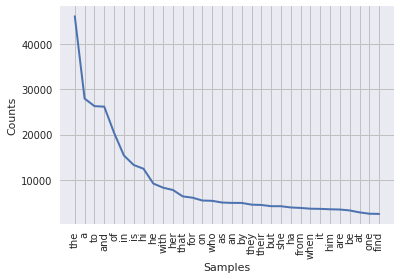

In [88]:
fdist.plot(32,cumulative=False)
plt.show()

In [80]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
print(stop_words)

{'s', "she's", "weren't", "that'll", 'under', "shouldn't", 'during', 'after', 'when', 'your', 'has', 'each', 'd', 'having', "you're", 're', 'myself', 'this', 'by', 'ain', "wouldn't", 'only', 'ours', 'been', 'on', 'before', 'about', 'more', 'between', 'ma', 've', 'very', 'him', 'for', 'isn', "needn't", 'didn', 'o', 'do', 'did', 'were', 'below', 'we', 'up', 'same', 'too', 'was', "isn't", 'a', 'not', 'don', 'or', 'our', 'll', 'won', 'if', 'himself', 'aren', 'what', 'had', "should've", 'its', "aren't", 'wouldn', 'who', 'needn', 'which', 'mustn', "hasn't", 'shouldn', 'yourselves', 'her', 'shan', 'be', 'they', 'theirs', 'should', 'until', 'few', 'all', 'yours', 'are', 'such', "you've", "it's", 'can', 'off', 'hadn', "wasn't", 'his', 'while', "you'd", 'where', 'haven', 'from', 'that', 'does', 'and', 'mightn', "hadn't", 'am', 'at', 'against', 'once', 'you', 'in', 'over', 'it', 'just', 'y', "you'll", 'other', 'with', 'into', 'so', 'is', "don't", "couldn't", 'will', 'my', 'wasn', 'down', 'doesn',

In [81]:
filtered_sent_lancaster=[]
for w in tokenized_word:
    if w not in stop_words:
        filtered_sent_lancaster.append(w)


In [82]:
tokenized_word

['in',
 'thi',
 'sprawling',
 'star',
 'lad',
 'film',
 'we',
 'see',
 'the',
 'struggles',
 'of',
 'vary',
 'french',
 'resist',
 'fact',
 'to',
 'regain',
 'control',
 'of',
 'par',
 'near',
 'the',
 'end',
 'of',
 'world',
 'war',
 'ii',
 'the',
 'naz',
 'gen',
 'in',
 'charg',
 'of',
 'par',
 'dietrich',
 'von',
 'cholitz',
 'fr',
 'be',
 'is',
 'und',
 'ord',
 'from',
 'hitl',
 'himself',
 'to',
 'burn',
 'the',
 'city',
 'if',
 'he',
 'can',
 'not',
 'control',
 'it',
 'or',
 'if',
 'the',
 'al',
 'get',
 'too',
 'clos',
 'much',
 'of',
 'the',
 'dram',
 'cent',
 'around',
 'the',
 'mor',
 'delib',
 'of',
 'the',
 'gen',
 'the',
 'swed',
 'ambassad',
 'wel',
 'and',
 'the',
 'eag',
 'but',
 'desp',
 'lead',
 'of',
 'the',
 'resist',
 'a',
 'crypt',
 'mess',
 'from',
 'the',
 'past',
 'send',
 'jam',
 'bond',
 'on',
 'a',
 'rog',
 'miss',
 'to',
 'mexico',
 'city',
 'and',
 'ev',
 'rom',
 'wher',
 'he',
 'meet',
 'luc',
 'the',
 'beauty',
 'and',
 'forbid',
 'widow',
 'of',
 'an',

In [83]:
filtered_sent_lancaster

['thi',
 'sprawling',
 'star',
 'lad',
 'film',
 'see',
 'struggles',
 'vary',
 'french',
 'resist',
 'fact',
 'regain',
 'control',
 'par',
 'near',
 'end',
 'world',
 'war',
 'ii',
 'naz',
 'gen',
 'charg',
 'par',
 'dietrich',
 'von',
 'cholitz',
 'fr',
 'und',
 'ord',
 'hitl',
 'burn',
 'city',
 'control',
 'al',
 'get',
 'clos',
 'much',
 'dram',
 'cent',
 'around',
 'mor',
 'delib',
 'gen',
 'swed',
 'ambassad',
 'wel',
 'eag',
 'desp',
 'lead',
 'resist',
 'crypt',
 'mess',
 'past',
 'send',
 'jam',
 'bond',
 'rog',
 'miss',
 'mexico',
 'city',
 'ev',
 'rom',
 'wher',
 'meet',
 'luc',
 'beauty',
 'forbid',
 'widow',
 'infam',
 'crimin',
 'bond',
 'infilt',
 'secret',
 'meet',
 'uncov',
 'ex',
 'sin',
 'org',
 'known',
 'spect',
 'meanwhil',
 'back',
 'london',
 'max',
 'denbigh',
 'new',
 'head',
 'cent',
 'nat',
 'sec',
 'quest',
 'bond',
 'act',
 'challeng',
 'relev',
 'mi',
 'led',
 'bond',
 'covert',
 'enl',
 'moneypenny',
 'q',
 'help',
 'seek',
 'madelein',
 'swan',
 'daug

In [84]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
merged_list = ''
for i in omdb_porter['omdb_plot']:
    merged_list = merged_list + i + ' '
tokenized_word = word_tokenize(merged_list)
fdist = FreqDist(tokenized_word)

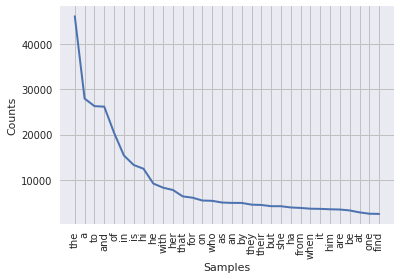

In [85]:
fdist.plot(32,cumulative=False)
plt.show()

In [89]:
filtered_sent_porter=[]
for w in tokenized_word:
    if w not in stop_words:
        filtered_sent_porter.append(w)

In [90]:
filtered_sent_porter

['thi',
 'sprawl',
 'star',
 'laden',
 'film',
 'see',
 'struggl',
 'variou',
 'french',
 'resist',
 'faction',
 'regain',
 'control',
 'pari',
 'near',
 'end',
 'world',
 'war',
 'ii',
 'nazi',
 'gener',
 'charg',
 'pari',
 'dietrich',
 'von',
 'cholitz',
 'fr',
 'order',
 'hitler',
 'burn',
 'citi',
 'control',
 'alli',
 'get',
 'close',
 'much',
 'drama',
 'center',
 'around',
 'moral',
 'deliber',
 'gener',
 'swedish',
 'ambassador',
 'well',
 'eager',
 'desper',
 'leader',
 'resist',
 'cryptic',
 'messag',
 'past',
 'send',
 'jame',
 'bond',
 'rogu',
 'mission',
 'mexico',
 'citi',
 'eventu',
 'rome',
 'meet',
 'lucia',
 'beauti',
 'forbidden',
 'widow',
 'infam',
 'crimin',
 'bond',
 'infiltr',
 'secret',
 'meet',
 'uncov',
 'exist',
 'sinist',
 'organis',
 'known',
 'spectr',
 'meanwhil',
 'back',
 'london',
 'max',
 'denbigh',
 'new',
 'head',
 'centr',
 'nation',
 'secur',
 'question',
 'bond',
 'action',
 'challeng',
 'relev',
 'mi',
 'led',
 'bond',
 'covertli',
 'enlist',
 

In [91]:
dic_saving_genres = {}
for index, genres in enumerate(filtered_genres):
    dic_saving_genres.update({genres: index})
dic_saving_genres

{'Action': 1,
 'Adventure': 2,
 'Comedy': 4,
 'Crime': 6,
 'Drama': 0,
 'Horror': 5,
 'Romance': 8,
 'Sci-Fi': 7,
 'Thriller': 3}

In [92]:
genres_comment = get_genres(omdb)

In [93]:
genres_comment

{'Action': ['a cryptic message from the past sends james bond on a rogue mission to mexico city and eventually rome where he meets lucia the beautiful and forbidden widow of an infamous criminal bond infiltrates a secret meeting and uncovers the existence of the sinister organisation known as spectre meanwhile back in london max denbigh the new head of the centre of national security questions bonds actions and challenges the relevance of mi led by m bond covertly enlists moneypenny and q to help him seek out madeleine swann the daughter of his old nemesis mr white who may hold the clue to untangling the web of spectre as the daughter of the assassin she understands bond in a way most others cannot as bond ventures towards the heart of spectre he learns a chilling connection between himself and the enemy he seeks',
  'captain jack sparrow depp crosses paths with a woman from his past cruz and hes not sure if its love or if shes a ruthless con artist whos using him to find the fabled fo

In [94]:
predict_df = pd.DataFrame(columns=['genres_number', 'plot'])

In [95]:
omdb

imdb_id                                        omdb_awards  \
0     tt0060814     Nominated for 2 Oscars. Another 2 nominations.   
1     tt2379713      Won 1 Oscar. Another 7 wins & 32 nominations.   
2     tt0230575                                                N/A   
3     tt0065988  Nominated for 1 Oscar. Another 5 wins & 8 nomi...   
4     tt1995390                                     2 nominations.   
5     tt0066921  Nominated for 4 Oscars. Another 9 wins & 19 no...   
6     tt1298650                           2 wins & 31 nominations.   
7     tt0069947  Nominated for 1 Oscar. Another 1 win & 10 nomi...   
8     tt0116629     Won 1 Oscar. Another 34 wins & 34 nominations.   
9     tt0057012  Nominated for 4 Oscars. Another 13 wins & 7 no...   
10    tt1568346     Won 1 Oscar. Another 27 wins & 90 nominations.   
11    tt1504320  Won 4 Oscars. Another 102 wins & 194 nominations.   
12    tt0120737  Won 4 Oscars. Another 113 wins & 123 nominations.   
13    tt0800080                             1 win & 8 nominations.   
14    tt1226229                                    14 nominations.   
15    tt2395427                           7 wins & 45 nominations.   
16    tt0368891                             1 win & 9 nominations.   
17    tt0057076  Nominated for 1 Golden Globe. Another 3 wins &...   
18    tt0371746  Nominated for 2 Oscars. Another 20 wins & 65 n...   
19    tt2381249                           6 wins & 23 nominations.   
20    tt0434409                           7 wins & 27 nominations.   
21    tt0816711                           3 wins & 24 nominations.   
22    tt0241527  Nominated for 3 Oscars. Another 17 wins & 62 n...   
23    tt0480249                           9 wins & 22 nominations.   
24    tt0115956                            9 wins & 7 nominations.   
25    tt1194173                            1 win & 11 nominations.   
26    tt2872732                            1 win & 11 nominations.   
27    tt0383574     Won 1 Oscar. Another 42 wins & 53 nominations.   
28    tt0102926    Won 5 Oscars. Another 54 wins & 44 nominations.   
29    tt0064757  Nominated for 1 Golden Globe. Another 1 win & ...   
...         ...                                                ...   
8846  tt0369738                                                N/A   
8847  tt3469798                                     2 nominations.   
8848  tt0432348                            4 wins & 8 nominations.   
8849  tt0220570                                            2 wins.   
8850  tt0029855  Nominated for 4 Oscars. Another 1 win & 1 nomi...   
8851  tt0299422                                             1 win.   
8852  tt0387564                           8 wins & 10 nominations.   
8853  tt1821362                                                N/A   
8854  tt3276924                                                N/A   
8855  tt3805180                                                N/A   
8856  tt0092033                                                N/A   
8857  tt0120514  Nominated for 1 Golden Globe. Another 4 wins &...   
8858  tt0078870                              1 win & 1 nomination.   
8859  tt1819769                                                N/A   
8860  tt0087313                                                N/A   
8861  tt2318405                            4 wins & 7 nominations.   
8862  tt0254617                                                N/A   
8863  tt0266489                                     2 nominations.   
8864  tt0280962                            4 wins & 2 nominations.   
8865  tt0298491                           10 wins & 3 nominations.   
8866  tt0978702                                                N/A   
8867  tt0096219                            3 wins & 5 nominations.   
8868  tt1986994                                                N/A   
8869  tt1183487                                            5 wins.   
8870  tt0113101                              1 win & 1 nomination.   
8871  tt0052365   

In [96]:
for index,genres in enumerate(omdb['omdb_genres']):
    for i in genres:
        row = [dic_saving_genres[i],omdb['omdb_plot'][index]]
        predict_df.loc[len(predict_df)] = row
predict_df

genres_number                                               plot
0                 0  in this sprawling star laden film we see the s...
1                 1  a cryptic message from the past sends james bo...
2                 2  a cryptic message from the past sends james bo...
3                 3  a cryptic message from the past sends james bo...
4                 4  the makers of this parody of night of the livi...
5                 5  the makers of this parody of night of the livi...
6                 2  jack crabb is years old as the film begins a c...
7                 4  jack crabb is years old as the film begins a c...
8                 0  jack crabb is years old as the film begins a c...
9                 6  when perry and his girlfriend gail cross paths...
10                0  when perry and his girlfriend gail cross paths...
11                3  when perry and his girlfriend gail cross paths...
12                6  protagonist alex delarge is an ultraviolent yo...
13                0  protagonist alex delarge is an ultraviolent yo...
14                7  protagonist alex delarge is an ultraviolent yo...
15                1  captain jack sparrow depp crosses paths with a...
16                2  captain jack sparrow depp crosses paths with a...
17                6  it is the early s in france the remaining surv...
18                0  it is the early s in france the remaining surv...
19                3  it is the early s in france the remaining surv...
20                1  on july nd communications systems worldwide ar...
21                2  on july nd communications systems worldwide ar...
22                7  on july nd communications systems worldwide ar...
23                4  paranoid brigadier general jack d ripper of bu...
24                6  this english language adaptation of the swedis...
25                0  this english language adaptation of the swedis...
26                4  englands prince albert must ascend the throne ...
27                0  englands prince albert must ascend the throne ...
28                2  an ancient ring thought lost for centuries has...
29                0  an ancient ring thought lost for centuries has...
...             ...                                                ...
17582             4  a rediscovered classic from director ken loach...
17583             0  ray enrolls in art school where he makes new f...
17584             4  estelle is a one person protest army she goes ...
17585             0  estelle is a one person protest army she goes ...
17586             1  in ww after a tank battle a wounded soviet tan...
17587             2  in ww after a tank battle a wounded soviet tan...
17588             4  a young woman is in orlando visiting her ailin...
17589             8  a young woman is in orlando visiting her ailin...
17590             4  alex rose and nancy kendricks are a young coup...
17591             6  a terrifying love triangle an original twist o...
17592             5  a terrifying love triangle an original twist o...
17593             8  a terrifying love triangle an original twist o...
17594             0  nicklas lives a pretty normal teenage life unt...
17595             3  nicklas lives a pretty normal teenage life unt...
17596             0  raghavendra vishnu chinna and vamsi are brothe...
17597             0  an acerbic radio talk show host based in dalla...
17598             5  season of the equinox the witch besets her kil...
17599             3  season of the equinox the witch besets her kil...
17600             0  colin mc nally couldnt give a toss about the p...
17601             4  this movie features the collaborative director...
17602             1  einar and eric are two viking half brothers th...
17603             2  einar and eric are two viking half brothers th...
17604             4  in lieu of love and affections from his multi ...
17605             0  in lieu of love and affections from his multi ...
17606             8  in lieu o

In [137]:
selector = SelectPercentile(f_classif, percentile=20)
vectorizer = TfidfVectorizer(max_df = 0.4,stop_words='english')
y = predict_df['genres_number'].astype('int')
X = predict_df['plot']
X_train, X_test, y_train, y_test = train_test_split(X,y)
X_train = vectorizer.fit_transform(X_train)
    
selector.fit(X_train,y_train)
X_train = selector.transform(X_train).toarray()
    
model = MultinomialNB(alpha=1 ,fit_prior = False)
model.fit(X_train,y_train)
X_test = vectorizer.transform(X_test)
X_test = selector.transform(X_test).toarray()
print(model.score(X_test,y_test))

0.30093118328412444


In [138]:
score_corr(model, X_test, y_test, predict_df)

The corrected score for testing data is:  0.8080853963206904


0.8080853963206904

In [120]:
predict_df_porter = pd.DataFrame(columns=['genres_number', 'plot'])
for index,genres in enumerate(omdb_porter['omdb_genres']):
    for i in genres:
        row = [dic_saving_genres[i],omdb_porter['omdb_plot'][index]]
        predict_df_porter.loc[len(predict_df_porter)] = row
predict_df_porter

genres_number                                               plot
0                 0  in thi sprawl star laden film we see the strug...
1                 1  a cryptic messag from the past send jame bond ...
2                 2  a cryptic messag from the past send jame bond ...
3                 3  a cryptic messag from the past send jame bond ...
4                 4  the maker of thi parodi of night of the live d...
5                 5  the maker of thi parodi of night of the live d...
6                 2  jack crabb is year old as the film begin a col...
7                 4  jack crabb is year old as the film begin a col...
8                 0  jack crabb is year old as the film begin a col...
9                 6  when perri and hi girlfriend gail cross path w...
10                0  when perri and hi girlfriend gail cross path w...
11                3  when perri and hi girlfriend gail cross path w...
12                6  protagonist alex delarg is an ultraviol youth ...
13                0  protagonist alex delarg is an ultraviol youth ...
14                7  protagonist alex delarg is an ultraviol youth ...
15                1  captain jack sparrow depp cross path with a wo...
16                2  captain jack sparrow depp cross path with a wo...
17                6  it is the earli s in franc the remain survivor...
18                0  it is the earli s in franc the remain survivor...
19                3  it is the earli s in franc the remain survivor...
20                1  on juli nd commun system worldwid are sent int...
21                2  on juli nd commun system worldwid are sent int...
22                7  on juli nd commun system worldwid are sent int...
23                4  paranoid brigadi gener jack d ripper of burpel...
24                6  thi english languag adapt of the swedish novel...
25                0  thi english languag adapt of the swedish novel...
26                4  england princ albert must ascend the throne as...
27                0  england princ albert must ascend the throne as...
28                2  an ancient ring thought lost for centuri ha be...
29                0  an ancient ring thought lost for centuri ha be...
...             ...                                                ...
17582             4  a rediscov classic from director ken loach the...
17583             0  ray enrol in art school where he make new frie...
17584             4  estel is a one person protest armi she goe to ...
17585             0  estel is a one person protest armi she goe to ...
17586             1  in ww after a tank battl a wound soviet tank d...
17587             2  in ww after a tank battl a wound soviet tank d...
17588             4  a young woman is in orlando visit her ail moth...
17589             8  a young woman is in orlando visit her ail moth...
17590             4  alex rose and nanci kendrick are a young coupl...
17591             6  a terrifi love triangl an origin twist on a st...
17592             5  a terrifi love triangl an origin twist on a st...
17593             8  a terrifi love triangl an origin twist on a st...
17594             0  nickla live a pretti normal teenag life until ...
17595             3  nickla live a pretti normal teenag life until ...
17596             0  raghavendra vishnu chinna and vamsi are brothe...
17597             0  an acerb radio talk show host base in dalla st...
17598             5  season of the equinox the witch beset her kill...
17599             3  season of the equinox the witch beset her kill...
17600             0  colin mc nalli couldnt give a toss about the p...
17601             4  thi movi featur the collabor directori effort ...
17602             1  einar and eric are two vike half brother the f...
17603             2  einar and eric are two vike half brother the f...
17604             4  in lieu of love and affect from hi multi milli...
17605             0  in lieu of love and affect from hi multi milli...
17606             8  in lieu o

In [105]:
selector = SelectPercentile(f_classif, percentile=20)
vectorizer = TfidfVectorizer(max_df = 0.4,stop_words='english')
y = predict_df_porter['genres_number'].astype('int')
X = predict_df_porter['plot']
X_train, X_test, y_train, y_test = train_test_split(X,y)
X_train = vectorizer.fit_transform(X_train)
    
selector.fit(X_train,y_train)
X_train = selector.transform(X_train).toarray()
    
model = MultinomialNB(alpha=1 ,fit_prior = False)
model.fit(X_train,y_train)
X_test = vectorizer.transform(X_test)
X_test = selector.transform(X_test).toarray()
print(model.score(X_test,y_test))

0.30183965478083125


In [106]:
score_corr(model, X_test, y_test, predict_df_porter)

The corrected score for testing data is:  0.8049057460822167


0.8049057460822167

In [109]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
#tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
selector = SelectPercentile(f_classif, percentile=20)
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(predict_df['plot'])

In [110]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, predict_df['genres_number'].astype('int'), test_size=0.3, random_state=1)

In [ ]:
# from sklearn.naive_bayes import MultinomialNB
# #Import scikit-learn metrics module for accuracy calculation
# from sklearn import metrics
# # Model Generation Using Multinomial Naive Bayes
# selector.fit(X_train,y_train)
# X_train = selector.transform(X_train).toarray()
# clf = MultinomialNB().fit(X_train, y_train)
# predicted= clf.predict(X_test)
# X_test = selector.transform(X_test).toarray()
# print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

In [111]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(omdb_porter['omdb_genres'])
y = multilabel_binarizer.transform(omdb_porter['omdb_genres'])
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000, stop_words = 'english')

X_train, X_test, y_train, y_test = train_test_split(omdb_porter['omdb_plot'], y, test_size=0.2, random_state=9)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)

f1_score(y_test, y_pred, average="micro")



0.5178939479108112

In [112]:
y_pred_prob = clf.predict_proba(X_test_tfidf)

t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

f1_score(y_test, y_pred_new, average="micro")

0.6399358460304732

In [113]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(omdb_porter['omdb_genres'])
y = multilabel_binarizer.transform(omdb_porter['omdb_genres'])
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
#tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)

X_train, X_test, y_train, y_test = train_test_split(omdb_porter['omdb_plot'], y, test_size=0.2, random_state=9)

X_train_tfidf = cv.fit_transform(X_train)
X_test_tfidf = cv.transform(X_test)

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)

f1_score(y_test, y_pred, average="micro")


0.5951296150824823

In [114]:
y_pred_prob = clf.predict_proba(X_test_tfidf)

t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

f1_score(y_test, y_pred_new, average="micro")

0.6183391939410333

In [115]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(omdb['omdb_genres'])
y = multilabel_binarizer.transform(omdb['omdb_genres'])
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000, stop_words = 'english')

X_train, X_test, y_train, y_test = train_test_split(omdb['omdb_plot'], y, test_size=0.2, random_state=9)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)

f1_score(y_test, y_pred, average="micro")



0.5004793863854267

In [116]:
y_pred_prob = clf.predict_proba(X_test_tfidf)

t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

f1_score(y_test, y_pred_new, average="micro")

0.6255210434314912

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tf=TfidfVectorizer()
# text_tf= tf.fit_transform(predict_df['plot'])

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     text_tf, predict_df['genres_number'].astype('int'), test_size=0.3, random_state=123)

In [ ]:
# from sklearn.naive_bayes import MultinomialNB
# from sklearn import metrics
# # Model Generation Using Multinomial Naive Bayes
# clf = MultinomialNB().fit(X_train, y_train)
# predicted= clf.predict(X_test)
# print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

In [ ]:
# https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/